#### Data Pre-process

In [1]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
### Preprocess functions

def preprocess_text(review):
    review = review.lower() # Convert text to lowercase / case folding
    review = re.sub(r"\d+", "", review) # Remove numbers
    review = re.sub(r'\W', r' ', review) # replace special character strings with empty string
    review = re.sub(r'\s+', r' ', review) # Reduce extra whitespaces between words
    review = review.strip() # Remove leading and ending spaces
    return review

def remove_stopwords(review):
    tokens = word_tokenize(review) # str to tokens
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if not i in stop_words] # remove stop words
    review = ' '.join(tokens)
    return review

def lemmatization(review):
    tokens = word_tokenize(review)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    review = ' '.join(tokens)
    return review


In [3]:
args = Namespace(                               
    input_munged_csv="movie_reviews.csv",
    output_munged_csv="movie_reviews_preprocessed.csv"
)

In [7]:
# review preprocessed data file
df1 = pd.read_csv(args.input_munged_csv)
df1.head()

,review_content,review_label
0,What happening to movie making 2021? Are they ...,Negative
1,"The action scenes are very , you can't take th...",Negative
2,"This complete rubbish is PC Bond, not James Bo...",Negative
3,"After they ruined Terminator, now comes the ti...",Negative
4,"This film is far, far, far too long. They coul...",Negative


Number of total review: 17367
Number of positive review: 9686
Number of negetive review: 7681


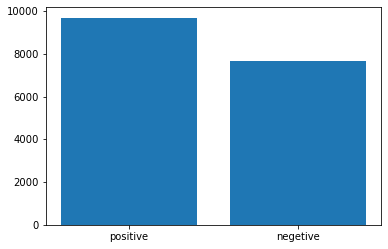

In [8]:
print('Number of total review:', df1['review_label'].count())
print('Number of positive review:', df1[df1['review_label'] == 'Positive'].count()[0])
print('Number of negetive review:', df1[df1['review_label'] == 'Negative'].count()[0])

plt.bar(['positive','negetive'], [df1[df1['review_label'] == 'Positive'].count()[0],df1[df1['review_label'] == 'Negative'].count()[0]])
plt.show()

In [9]:
# preprocess raw review content
df1.review_content = df1.review_content.apply(preprocess_text)
df1.review_content = df1.review_content.apply(remove_stopwords)
df1.review_content = df1.review_content.apply(lemmatization)

In [10]:
# label for positve = 1; negative = 0
df1.review_label = df1.review_label.apply({'Negative':0,'Positive':1}.get)

In [11]:
# save preprocessed data
df1.to_csv(args.output_munged_csv, index=False)

In [12]:
# review preprocessed data file
df2 = pd.read_csv(args.output_munged_csv).dropna() 
df2.head()

,review_content,review_label
0,happening movie making destroy every classic w...,0
1,action scene take away especially new female a...,0
2,complete rubbish pc bond james bond ian flemin...,0
3,ruined terminator come time bond endure hour w...,0
4,film far far far long could comfortably left m...,0


#### Text Classification using Scikit-Learn

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Number of total review: 17366
Number of positive review: 9685
Number of negetive review: 7681


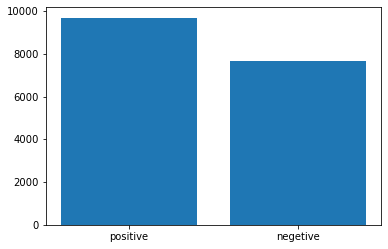

In [14]:
### STEP 1 - Corpus collection

# Load data
seed_number = 1234

df = pd.read_csv(args.output_munged_csv).dropna()   # after reprocessing, some review may become NaN

# Explore data
print('Number of total review:', df['review_label'].count())
print('Number of positive review:', df[df['review_label'] == 1].count()[0])
print('Number of negetive review:', df[df['review_label'] == 0].count()[0])

plt.bar(['positive','negetive'], [df[df['review_label'] == 1].count()[0],df[df['review_label'] == 0].count()[0]])
plt.show()

The number of total data: 17366
The number of training data: 15629
The number of test data: 1737


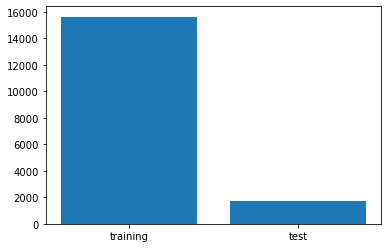

In [15]:
# split data into training and test dataset
# Assign X=> review, y=> label
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['review_content'], 
                                                            df['review_label'], 
                                                            test_size=0.1, 
                                                            random_state=seed_number, 
                                                            stratify=df['review_label'])
print(f'The number of total data: {len(X_train_raw) + len(X_test_raw)}')
print(f'The number of training data: {len(X_train_raw)}')
print(f'The number of test data: {len(X_test_raw)}')

plt.bar(['training','test'], [len(X_train_raw),len(X_test_raw)])
plt.show()

In [16]:
### Step 2 - Declare Features Vectors 

# Create TfidfVectorizer.
vectorizer = TfidfVectorizer(use_idf=True)

# Fit and transform
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

print('TF-IDF vectors:\n',X_train.todense())
print('Vocabulary:\n',vectorizer.vocabulary_)

TF-IDF vectors:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocabulary:
 {'best': 2545, 'murder': 18388, 'mystery': 18474, 'movie': 18264, 'funny': 11260, 'suspenseful': 27555, 'ending': 9042, 'everyone': 9531, 'wanted': 30836, 'way': 30963, 'daniel': 6564, 'craig': 6049, 'amazing': 867, 'maybe': 17218, 'need': 18685, 'time': 28502, 'think': 28297, 'right': 23696, 'disappointed': 7591, 'film': 10407, 'hate': 12697, 'loved': 16502, 'cinematography': 4726, 'shot': 25237, 'composition': 5339, 'florence': 10717, 'pugh': 22000, 'performance': 20503, 'pretty': 21579, 'fantastic': 10072, 'actor': 300, 'good': 11879, 'others': 19655, 'love': 16498, 'ari': 1375, 'aster': 1602, 'direction': 7538, 'previous': 21596, 'hereditary': 12955, 'make': 16810, 'one': 19431, 'even': 9498, 'disappointing': 7593, 'thought': 28343, 'repetitive': 23212, 'boring': 3152, 'lot': 16467, 'scene': 24428, 

In [17]:
### STEP 4 - Prediction

# Create and run Classifier
classifier = LogisticRegression()

# Fitting requires training TF_IDF vectors and labels
classifier.fit(X_train, y_train)

# X_test is the transformed test TF-IDF vectors
predictions = classifier.predict(X_test)

In [18]:
# show test results
print(classification_report(y_test, predictions))  

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       768
           1       0.94      0.94      0.94       969

    accuracy                           0.94      1737
   macro avg       0.94      0.94      0.94      1737
weighted avg       0.94      0.94      0.94      1737



     True  positive  negetive
Predicted                    
positive        714        54
negetive         54       915


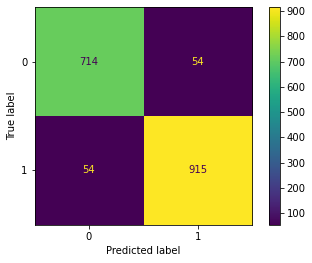

In [19]:
from sklearn.metrics import plot_confusion_matrix
# show confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm.T, index=['positive', 'negetive'], columns=['positive', 'negetive'])
cm_df.index.name = 'Predicted'
cm_df.columns.name = '     True'
print(cm_df)

# Plot non-normalized confusion matrix
plot_confusion_matrix(classifier, X_test, y_test)

In [20]:
### STEP 5 - Evaluation

# cross_val_score: Return the mean accuracy on the given test data and labels.
accuracy = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
precisions = cross_val_score(classifier, X_train, y_train, cv=5, scoring='precision')
recalls = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall') 
f1s = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')

print('Accuracy:', np.mean(accuracy), accuracy)
print('Precision:', np.mean(precisions), precisions)
print('Recall:', np.mean(recalls), recalls)
print('F1:', np.mean(f1s), f1s)

Accuracy: 0.93345756621881 [0.92930262 0.92898273 0.9328215  0.93442099 0.94176   ]
Precision: 0.9417649098724213 [0.93638968 0.93883439 0.94589878 0.94297235 0.94472934]
Recall: 0.9387335712443484 [0.93692661 0.93344808 0.93287435 0.93918531 0.95123351]
F1: 0.9402356532815077 [0.93665807 0.93613349 0.93934142 0.94107502 0.94797027]


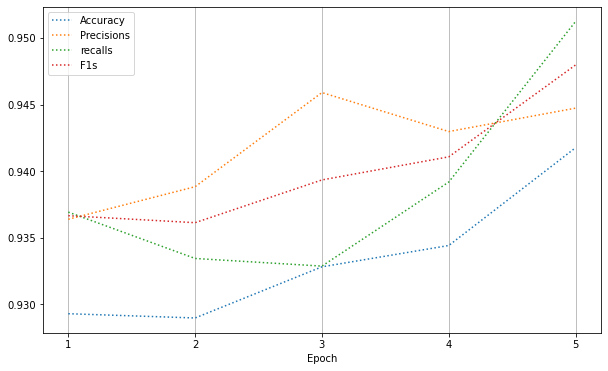

In [21]:
# plot lines of each epoch
plt.figure(figsize=(10,6))
x = [1,2,3,4,5]

plt.plot(x, accuracy, label = "Accuracy", linestyle=":")
plt.plot(x, precisions, label = "Precisions", linestyle=":")
plt.plot(x, recalls, label = "recalls", linestyle=":")
plt.plot(x, f1s, label = "F1s", linestyle=":")

plt.xticks(ticks=x, labels=x)
plt.xlabel("Epoch")
plt.grid(axis='x')
plt.legend()
plt.show()